# Calculate the SVD of the cross-Grammian matrix, calculate the favorable bases, and do some tests
As in the two-by-two worksheet, lets work with two levels of dyadic field. Then we'll construct our basis and do some tests.

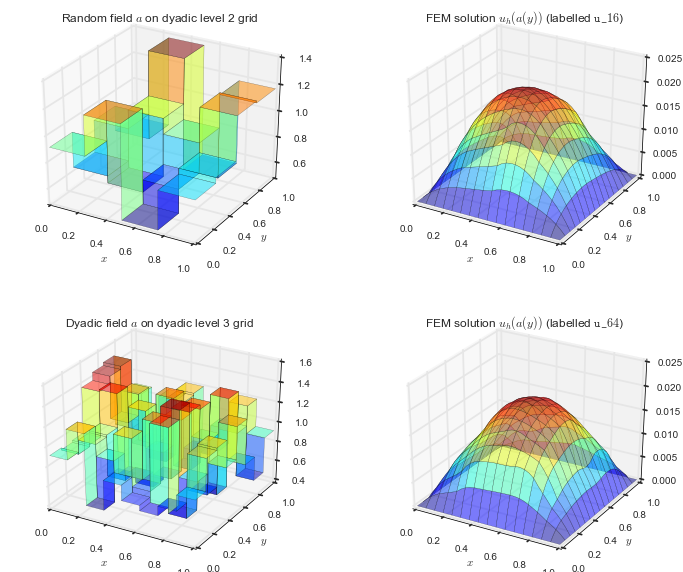

In [ ]:
import numpy as np
import importlib
import dyadic_fem as df
import seaborn as sns
import matplotlib.pyplot as plt
import pdb
importlib.reload(df)
%matplotlib inline

fem_div = 5

a_16 = df.make_dyadic_random_field(div=2, a_bar=1.0, c=0.5, seed=1)
fem_16 = df.DyadicFEMSolver(div=fem_div, rand_field=a_16, f=1.0)
fem_16.solve()

a_64 = df.make_dyadic_random_field(div=3, a_bar=1.0, c=0.5, seed=1)
fem_64 = df.DyadicFEMSolver(div=fem_div, rand_field=a_64, f=1.0)
fem_64.solve()

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(2, 2, 1, projection='3d')
a_16.plot(ax, title='Random field $a$ on dyadic level 2 grid')
ax = fig.add_subplot(2, 2, 2, projection='3d')
fem_16.u.plot(ax, title='FEM solution $u_h(a(y))$ (labelled $\mathtt{u\_16}$)')
ax = fig.add_subplot(2, 2, 3, projection='3d')
a_64.plot(ax, title='Dyadic field $a$ on dyadic level 3 grid')
ax = fig.add_subplot(2, 2, 4, projection='3d')
fem_64.u.plot(ax, title='FEM solution $u_h(a(y))$ (labelled $\mathtt{u\_64}$)')
plt.show()

### Now lets construct our bases, do the SVD, test the reconstruction in the original and favorable basis form

In [ ]:
m = 64
n = 40
local_width = 2**(fem_div - 4)

W_m = df.make_random_local_integration_basis(m=m, div=fem_div, width=local_width, space='H1')
W_ortho = W_m.orthonormalise()

# This is the measurement vector
w_16 = W_ortho.dot(fem_16.u)
u_p_w_16 = W_ortho.project(fem_16.u)
w_64 = W_ortho.dot(fem_64.u)
u_p_w_64 = W_ortho.project(fem_64.u)

V_n_16, V_fields = df.make_random_basis(n=n, field_div=2, fem_div=fem_div, space='H1')
V_n_64, V_fields = df.make_random_basis(n=n, field_div=3, fem_div=fem_div, space='H1')
V_n_16 = V_n_16.orthonormalise()
V_n_64 = V_n_64.orthonormalise()

u_p_v_16 = V_n_16.project(fem_16.u)
u_p_v_64 = V_n_64.project(fem_64.u)

u_star, v_star, w_recon, v_proj, cond = df.optimal_reconstruction(W_ortho, V_n_16, w_16, disp_cond=False)
#u_star, v_star, w_recon, v_proj, cond = df.optimal_reconstruction(W_ortho, V_n_64, w_64, disp_cond=False)

# Ok - here's the SVD calculation that we've been wanting to do

G = W_ortho.cross_grammian(V_n_16)
U,S,V = np.linalg.svd(G)
    
print('Beta(Wm, Vn) = {0}'.format(S[-1]))

# Now, lets construct the favourable basis from U and V
# NB I don't know why we need U.T... but it's the only thing that worked,
# from much experimentation...
W_m_star = W_ortho.ortho_matrix_multiply(U.T)
V_n_star = V_n_16.ortho_matrix_multiply(V)

W_m_star.make_grammian()
V_n_star.make_grammian()

print(type(W_m_star), type(V_n_star))
print('V: (Only the first 4 rows and columns)')
print(V[:4,:4])
print('Orthogonality test, V.T * V:')
print((V @ V.T)[:4,:4])
print('W* Grammian')
print(W_m_star.G[:4,:4])
print('V* Grammian')
print(V_n_star.G[:4,:4])

# We test the cross grammian
G_star = W_m_star.cross_grammian(V_n_star)
print('Cross Grammian of favorable basis')
print(G_star[:4,:4])
G_star_diag = [G_star[i,i] for i in range(min(G_star.shape[0],G_star.shape[1]))]
print('First few values of diagonal of favorable basis cross-Grammian')
print(G_star_diag[:5])
print('First few S values')
print(S[:5])

per_row = 6

fig = plt.figure(figsize=(15, 6))
for i in range(per_row):
    ax = fig.add_subplot(2, per_row, i+1, projection='3d')    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    W_m_star.vecs[i].plot(ax, title='$\omega_{{{0}}}^*$'.format(i), show_axes_labels=False)
    ax = fig.add_subplot(2, per_row, i+1+per_row, projection='3d')    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    V_n_star.vecs[i].plot(ax, title='$\phi_{{{0}}}^*$'.format(i), show_axes_labels=False)
plt.show()

These favorable bases should hold some properties, mainly with regards to the optimal reconstruction. We have that 
$$
A^*(\omega_i^*) = 
\begin{cases}
s_i^{-1} \phi_i^* & \text{for } 1\le i\le n \\
\omega_i^* & \text{for } n<i \le m
\end{cases}
$$
So we merely need to find the representation of the measurement $w$ in terms of the $\omega_i^*$ elements, i.e. $w=\sum_{i=1}^m w_i^* \omega_i^*$, then as $A^*$ is linear
$$
A^*(w) = A^*\left(\sum_{i=1}^m w_i^* \omega_i^*\right) = \sum_{i=1}^n w_i^* s_i^{-1} \phi_i^* + \sum_{i=n+1}^m w_i^* \omega_i^*
$$
Here we just double check that this construction agrees with the previous reconstruction. We have that $w_j^* = \sum_{i=1}^n u_{i,j} w_i$ as well as $w_j^* = \langle u, \omega_j^* \rangle$. We check both below.

In [ ]:
w_star = U.T @ w_16
w_star_check = W_m_star.dot(fem_16.u)

print('|| U.T w - sum <u, w_i*> ||_2 = {0}'.format(np.linalg.norm(w_star - w_star_check)))

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 3, 1, projection='3d')
u_p_w_16.plot(ax, title='Projection of $u_h$ in $W_m$')
ax = fig.add_subplot(1, 3, 2, projection='3d')
W_m_star.reconstruct(w_star).plot(ax, title='Projection of $u_h$ in $W_m^*$')
ax = fig.add_subplot(1, 3, 3, projection='3d')
(u_p_w_16 - W_m_star.reconstruct(w_star)).plot(ax, title='Difference')
ax.dist = 11

# Lets just test that reconstruction property the A*(w*_i) = ... in terms of favorable bases

A_w_star, A_v_star, A_w_recon, A_v_proj, cond = df.optimal_reconstruction(W_ortho, V_n_16, W_ortho.dot(W_m_star.vecs[0]), disp_cond=False)

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 3, 1, projection='3d')
A_w_star.plot(ax, title='Reconstruction of $\omega_i^*$ using original $W_m$ and $V_n$')
ax = fig.add_subplot(1, 3, 2, projection='3d')
(V_n_star.vecs[0] / S[0]).plot(ax, title='$\phi_i^* s_i^{-1}$ (i.e. reconstruction of $\omega_i^*$ using favorable basis)')
ax = fig.add_subplot(1, 3, 3, projection='3d')
(A_w_star - V_n_star.vecs[0] / S[0]).plot(ax, title='Difference')
ax.dist = 11


# Now look at the difference in the reconstruction algorithm

w_star_tail = np.zeros(w_star.shape)
w_star_tail[n:] = w_star[n:]
u_star_favorable = V_n_star.reconstruct(w_star[:n] / S) + W_m_star.reconstruct(w_star_tail)

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 3, 1, projection='3d')
u_star.plot(ax, title='Reconstruction $A*(u)$')
ax = fig.add_subplot(1, 3, 2, projection='3d')
u_star_favorable.plot(ax, title='Reconstruction via favorable bases')
ax = fig.add_subplot(1, 3, 3, projection='3d')
(u_star - u_star_favorable).plot(ax, title='Difference')
ax.dist = 11



One last question before we go... what is $v^*$ in terms of the favorable basis? Quite simply we have that
$$
v^*(w) = \sum_i w_i \phi_i s_i^{-1}
$$
where remember $w_i$ have to be in terms of $\omega_i^*$

In [ ]:
A_v_star = V_n_star.reconstruct(w_star[:n] / S)

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 3, 1, projection='3d')
v_star.plot(ax, title='v^*(u) from the original basis pair')
ax = fig.add_subplot(1, 3, 2, projection='3d')
A_v_star.plot(ax, title='$v^*$ from the favorable basis construction')
ax = fig.add_subplot(1, 3, 3, projection='3d')
(v_star - A_v_star).plot(ax, title='Difference')
ax.dist = 11


### Now we test our implementation of the BasisPair class that implements all this stuff...

In [ ]:
BP = df.BasisPair(W_ortho, V_n_16)
FB = BP.make_favorable_basis()

us_bp, vs_bp, wp_bp, vwp_bp, cond = BP.measure_and_reconstruct(fem_16.u)
us_fb, vs_fb, wp_fb, vwp_fb = FB.measure_and_reconstruct(fem_16.u)

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 3, 1, projection='3d')
us_bp.plot(ax, title='Reconstruction $A*(u)$')
ax = fig.add_subplot(1, 3, 2, projection='3d')
us_fb.plot(ax, title='Reconstruction via favorable bases')
ax = fig.add_subplot(1, 3, 3, projection='3d')
(us_bp - us_fb).plot(ax, title='Difference')
ax.dist = 11
